In [25]:
import pandas as pd
INPATH = "../2_processed_data/trade_model_data_all.csv"
df = pd.read_csv(INPATH)

In [26]:
df = df[df["Report ISO"]. str.upper() == "AUS"].copy()
df["year"] = pd.to_numeric(df["year"], errors="coerce")
df["trade"] = pd.to_numeric(df["trade"], errors="coerce")
df = df.dropna(subset=["year", "trade"])
df["year"] = df["year"].astype(int)


agg_cols = ["group", "Element", "year"]
df_agg = df.groupby(agg_cols, as_index=False)["trade"].sum()

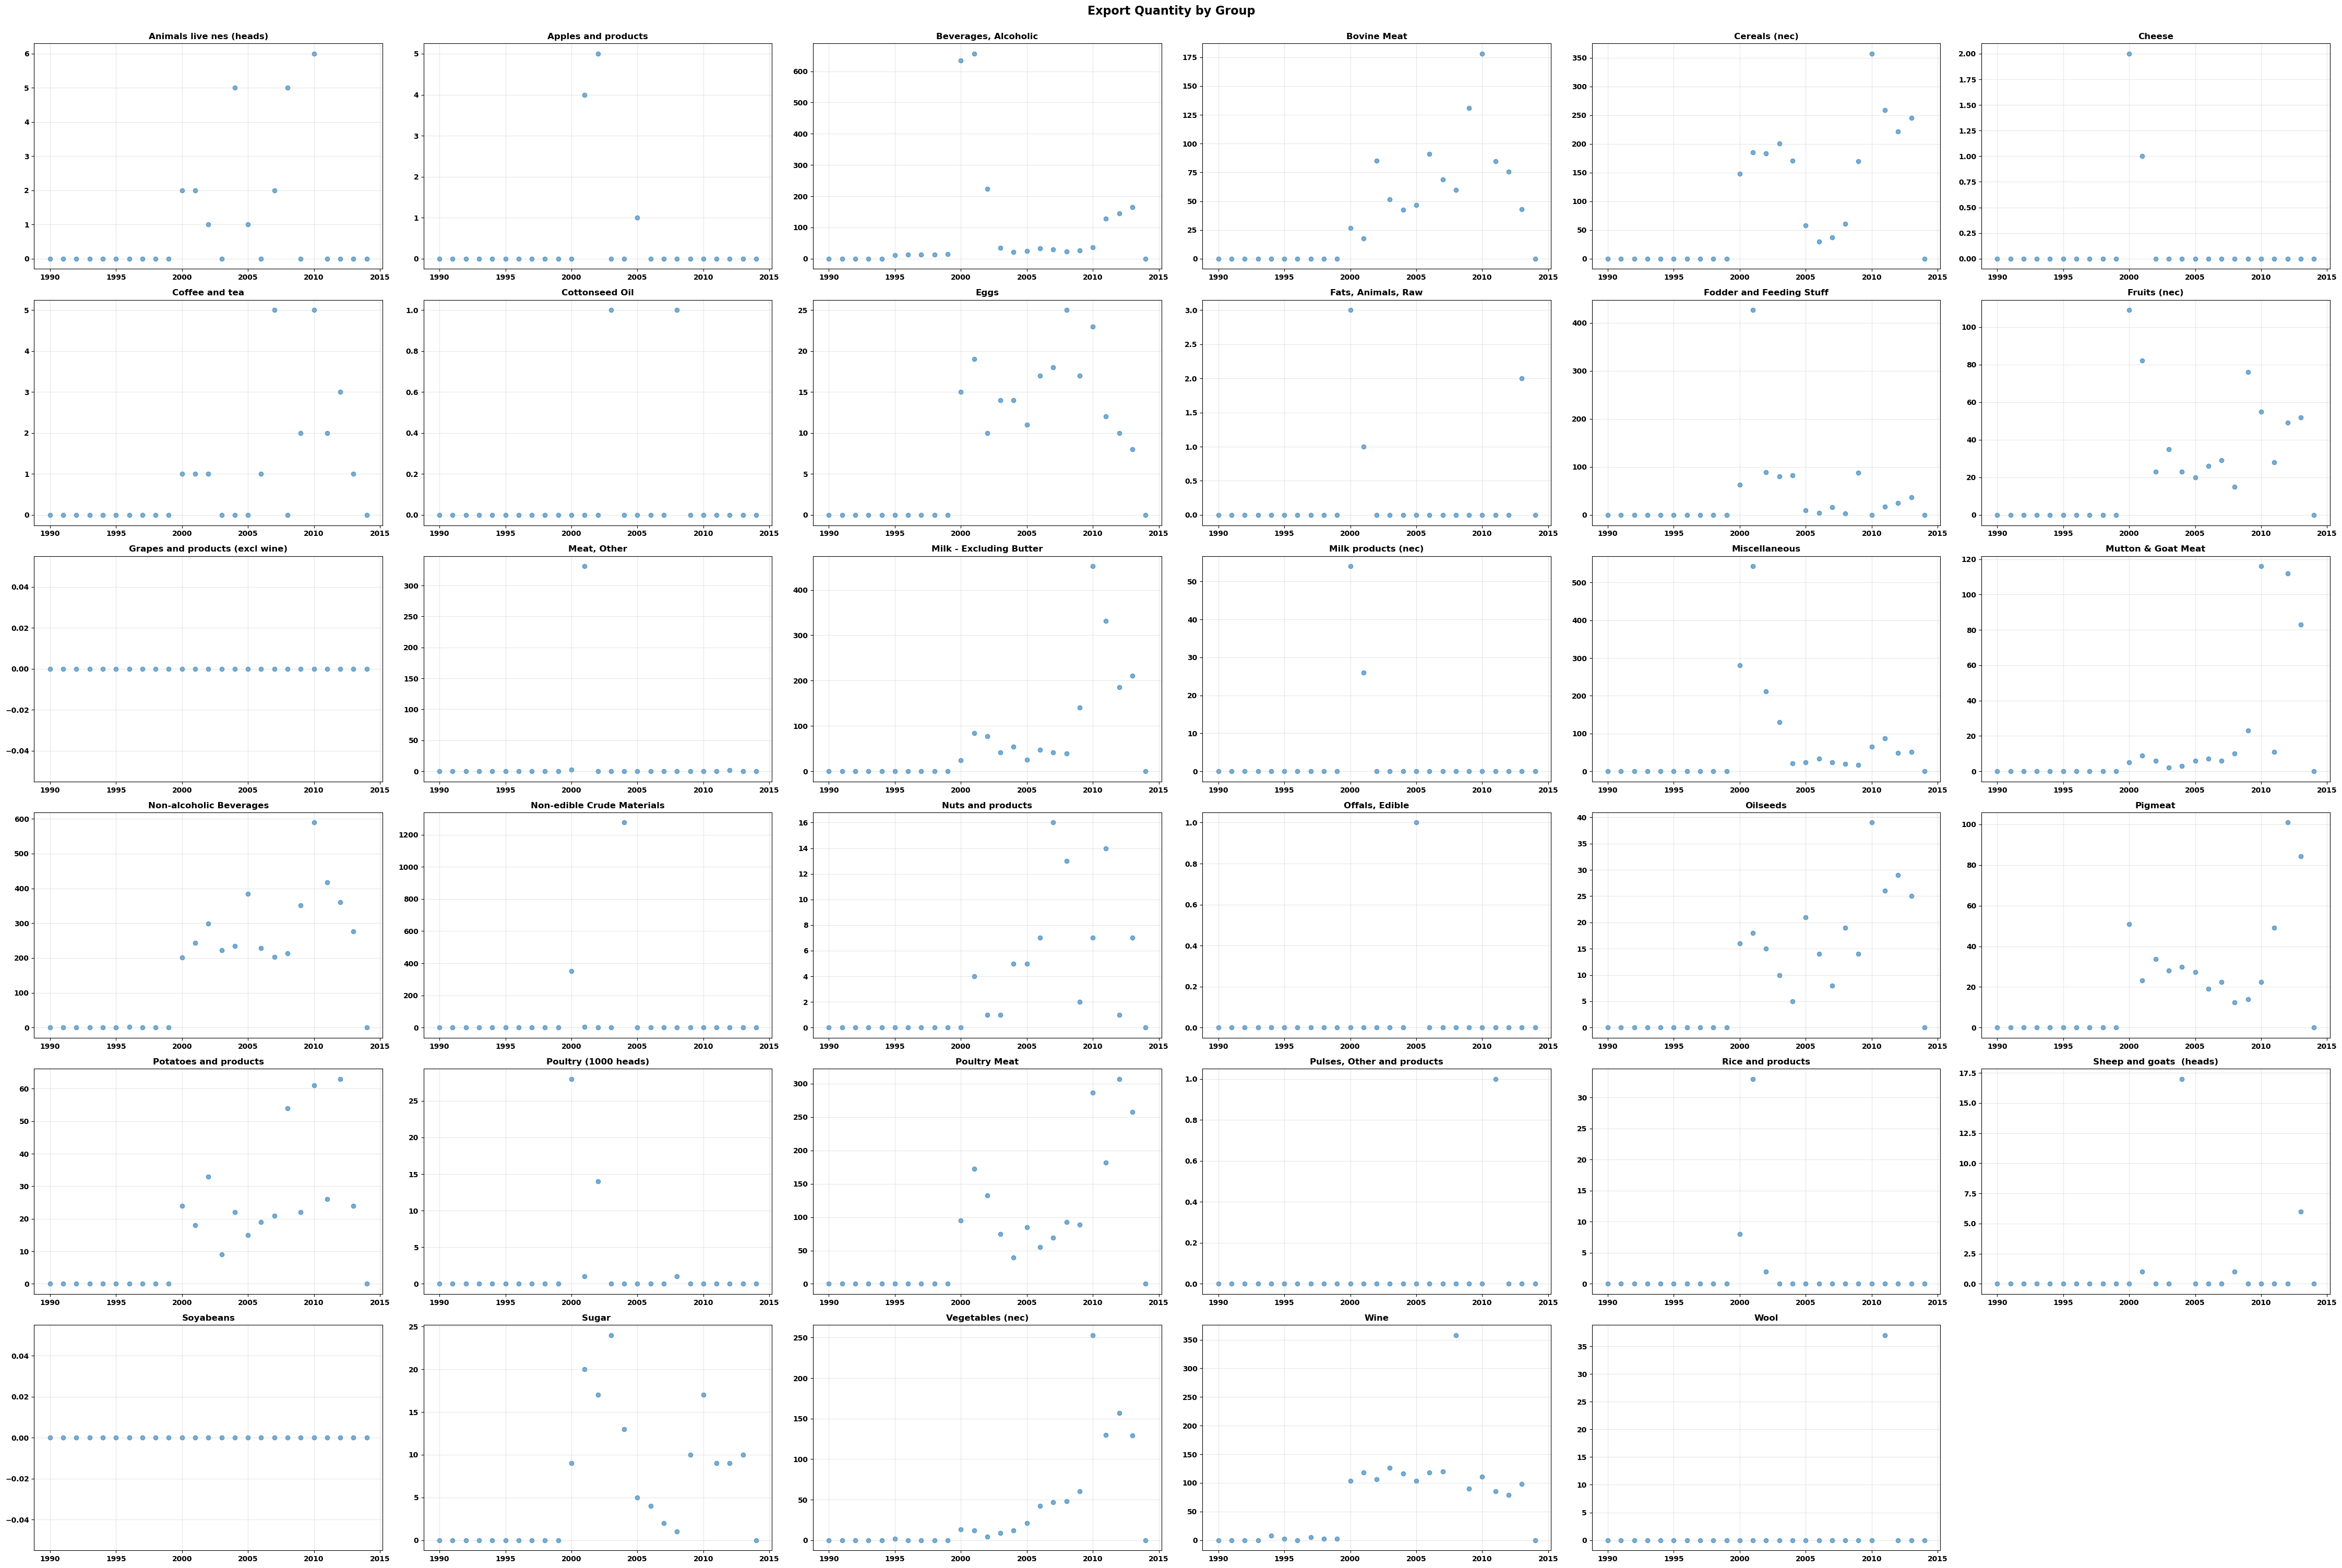

In [27]:
import matplotlib.pyplot as plt
import numpy as np

# 筛选 Element 列为 'Export Quantity' 的数据
df_filtered = df_agg[df_agg['Element'] == 'Export Quantity']

# 获取 group 列的所有唯一值
groups = df_filtered['group'].unique()

# 计算子图的行列数
n_groups = len(groups)
n_cols = 6  # 每行3个子图
n_rows = int(np.ceil(n_groups / n_cols))

# 创建子图
fig, axes = plt.subplots(n_rows, n_cols, figsize=(45, 5*n_rows))
axes = axes.flatten()  # 将axes展平为一维数组，方便索引

# 为每个 group 创建一个散点图
for idx, group in enumerate(groups):
    # 筛选当前 group 的数据
    df_group = df_filtered[df_filtered['group'] == group]
    
    # 在对应的子图上绘制散点图
    axes[idx].scatter(df_group['year'], df_group['trade'], alpha=0.6)
    axes[idx].set_xlabel('')
    axes[idx].set_ylabel('')
    axes[idx].set_title(f'{group}')
    axes[idx].grid(True, alpha=0.3)

# 隐藏多余的空白子图
for idx in range(n_groups, len(axes)):
    axes[idx].set_visible(False)

plt.suptitle('Export Quantity by Group', fontsize=16, y=1.00)
plt.tight_layout()
plt.show()

加载数据...
历史数据: 2250 行
训练模型:  85 个

总共 42 个Export商品
布局:  7 行 × 6 列

✓ 保存到:  ./export_predictions_bayes_all.png


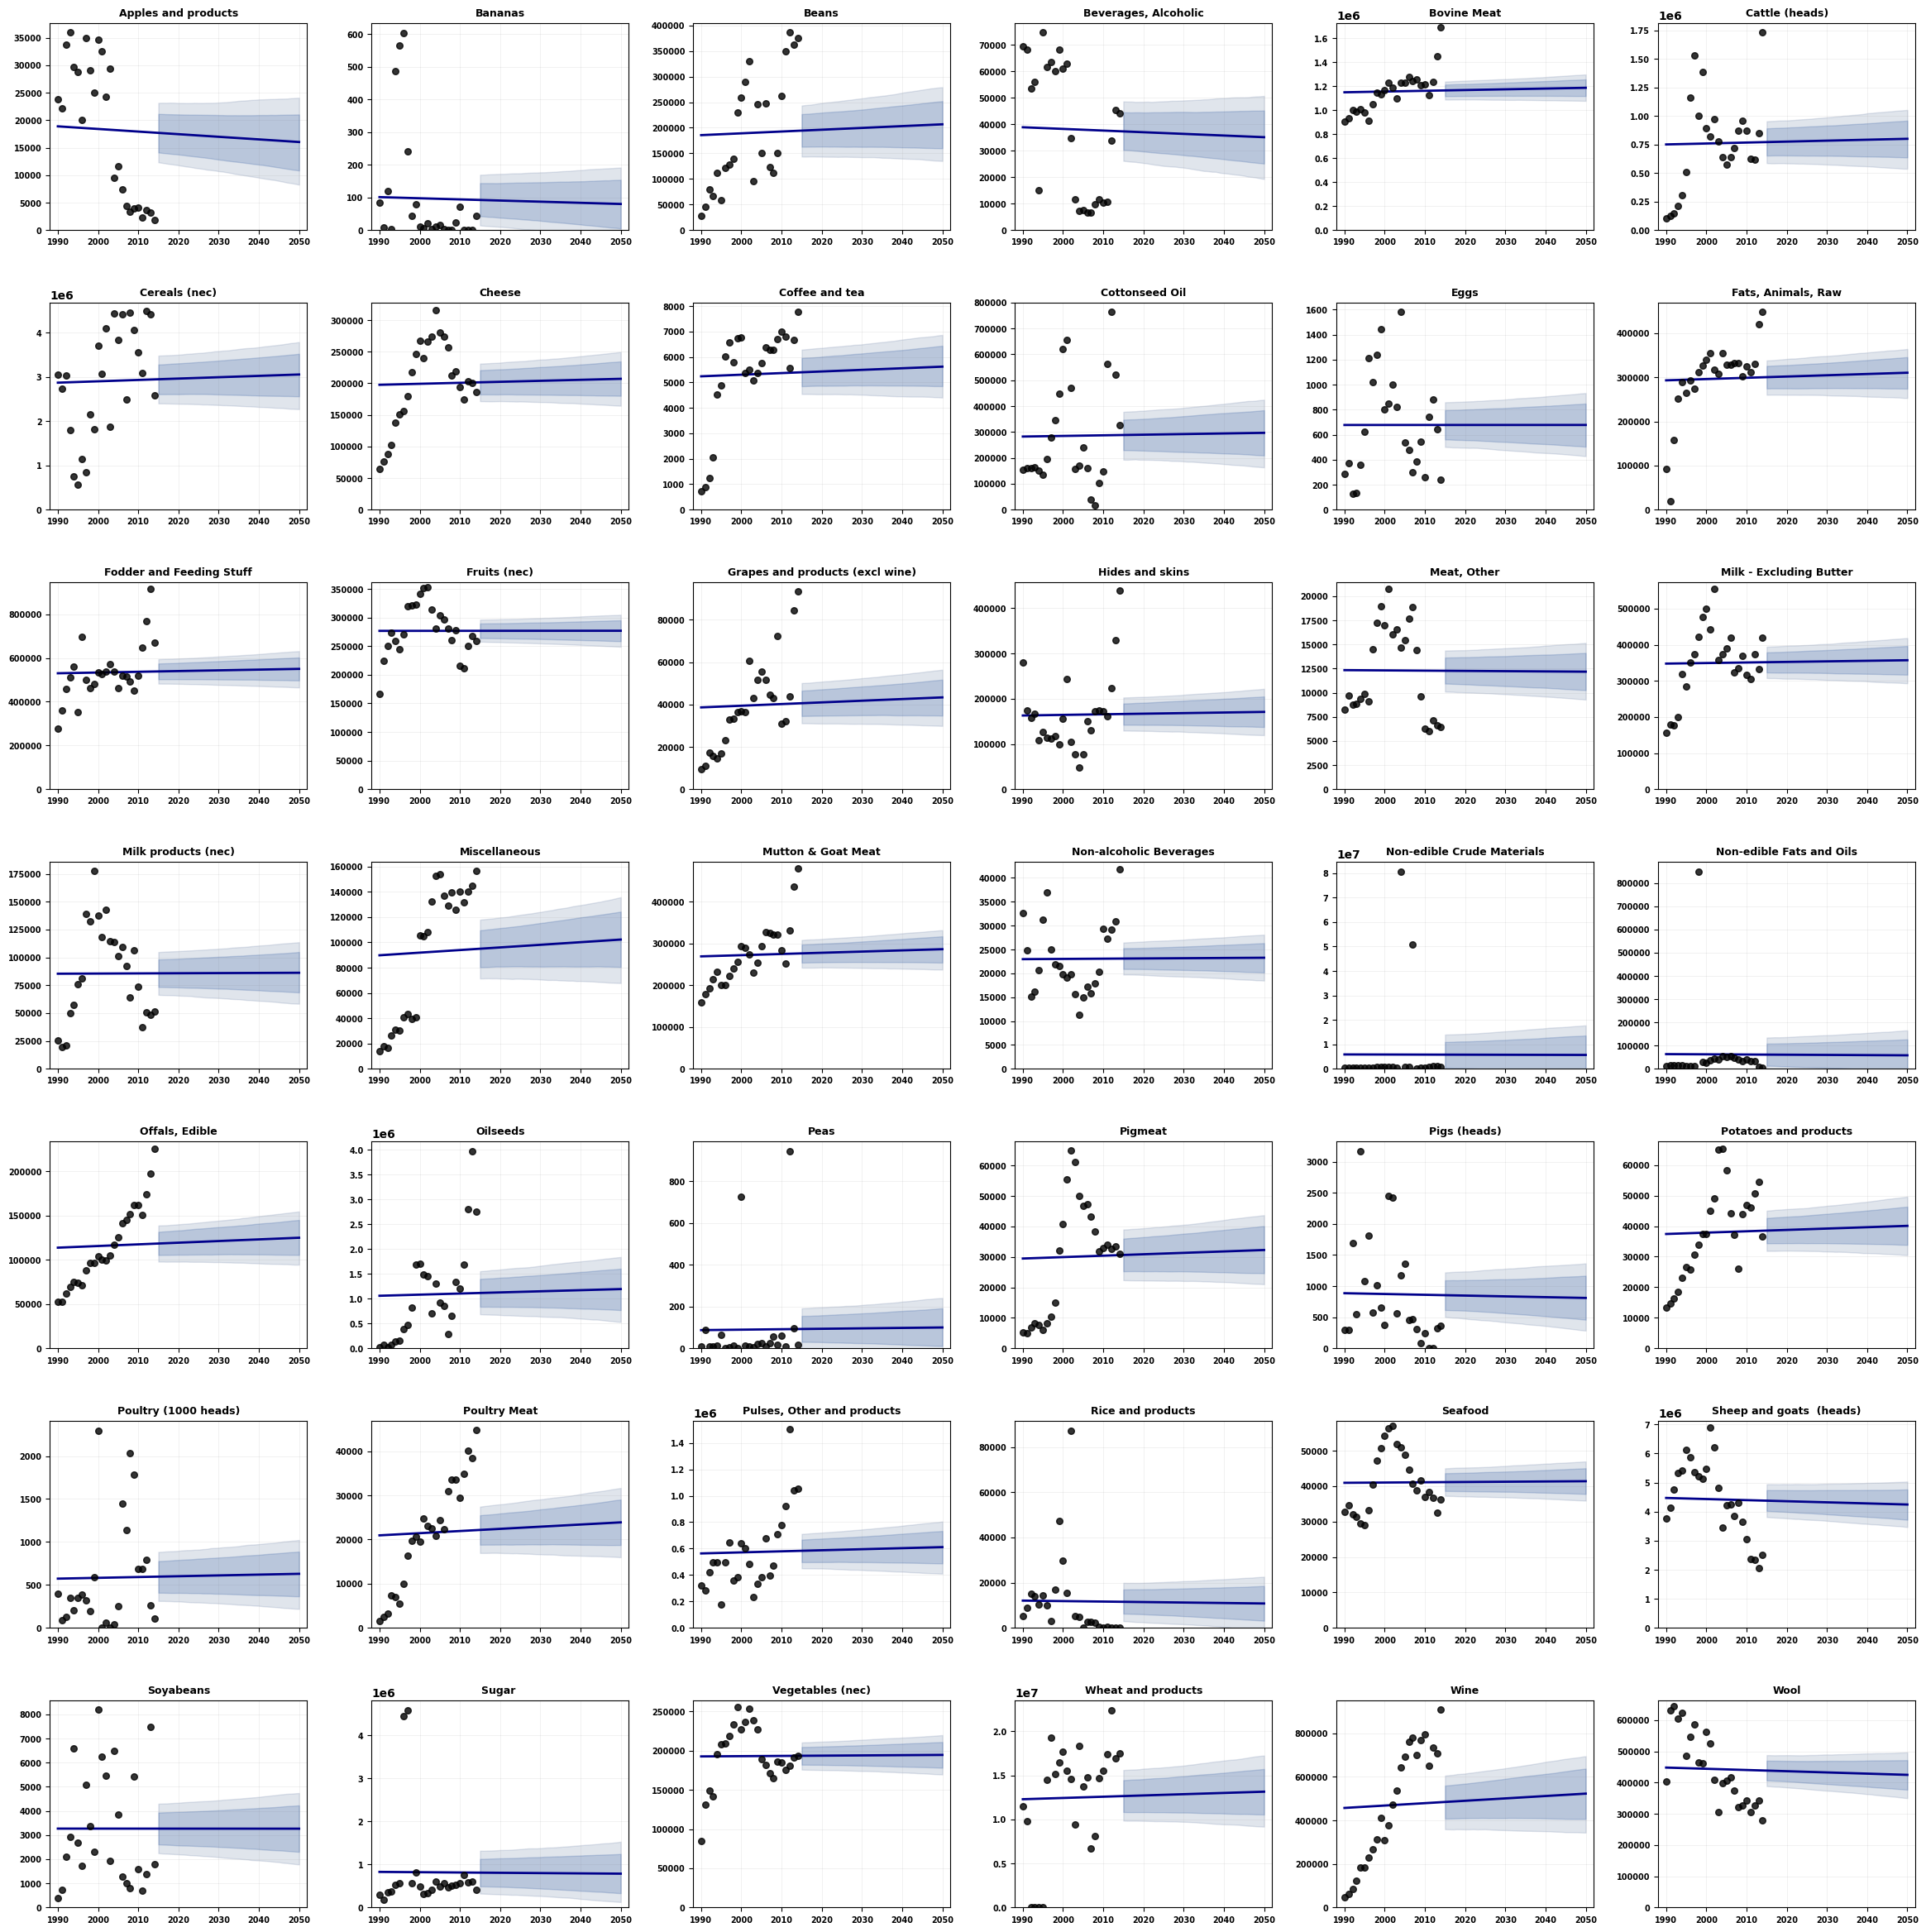


完成！


In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle
from pathlib import Path
from matplotlib.gridspec import GridSpec


def predict_from_posterior(alpha_samples, beta_samples, years):
    """
    使用后验样本生成预测和预测区间
    添加零下限（zero floor）
    
    返回:  DataFrame(Year, Mean, Lower_80, Upper_80, Lower_95, Upper_95)
    """
    predictions = []
    
    for year in years:
        # 用所有后验样本预测
        pred_samples = alpha_samples + beta_samples * year
        
        predictions.append({
            'Year': int(year),
            'Mean':  float(np.maximum(pred_samples. mean(), 0)),  # 零下限
            'Lower_80': float(np. maximum(np.percentile(pred_samples, 10), 0)),  # 零下限
            'Upper_80': float(np.maximum(np.percentile(pred_samples, 90), 0)),  # 零下限
            'Lower_95': float(np.maximum(np.percentile(pred_samples, 2.5), 0)),  # 零下限
            'Upper_95': float(np.maximum(np.percentile(pred_samples, 97.5), 0)),  # 零下限
        })
    
    return pd. DataFrame(predictions)


def plot_all_exports_bayes(df_hist:  pd.DataFrame, trained_models: list, save_path: str):
    """
    使用贝叶斯后验样本画图，所有Export商品在一张大图上
    添加零下限（zero floor）
    """
    
    # 只选Export Quantity
    element_name = 'Export Quantity'
    
    # 筛选 Export 商品
    export_models = [m for m in trained_models if m['element'] == element_name]
    export_models = sorted(export_models, key=lambda x: x['group'])
    
    n_groups = len(export_models)
    print(f"总共 {n_groups} 个Export商品")
    
    # 计算子图布局
    n_cols = 6
    n_rows = int(np.ceil(n_groups / n_cols))
    
    print(f"布局:  {n_rows} 行 × {n_cols} 列")
    
    # 创建大图
    fig = plt.figure(figsize=(24, 3.5 * n_rows))
    gs = GridSpec(n_rows, n_cols, figure=fig, hspace=0.35, wspace=0.25,
                  left=0.04, right=0.98, top=0.98, bottom=0.05)
    
    # 为每个商品画子图
    for idx, model_result in enumerate(export_models):
        row = idx // n_cols
        col = idx % n_cols
        ax = fig.add_subplot(gs[row, col])
        
        group_name = model_result['group']
        alpha_samples = model_result['alpha_samples']
        beta_samples = model_result['beta_samples']
        
        # 筛选历史数据
        hist_data = df_hist[
            (df_hist['group'] == group_name) & 
            (df_hist['Element'] == element_name) &
            (df_hist['year'] <= 2014)
        ].copy()
        
        if hist_data.empty:
            ax. text(0.5, 0.5, 'No Data', ha='center', va='center', transform=ax.transAxes)
            ax.set_title(group_name, fontsize=9, fontweight='bold')
            continue
        
        # 排序
        hist_data = hist_data.sort_values('year')
        
        # 生成预测 (从历史起始年到 2050)
        hist_start_year = int(hist_data['year']. min())
        years = np. arange(hist_start_year, 2051)
        pred_df = predict_from_posterior(alpha_samples, beta_samples, years)
        
        # 分离历史期和未来期
        pred_future = pred_df[pred_df['Year'] > 2014]. copy()
        
        # 1. 画预测区间（只画 2015 之后的）
        if not pred_future.empty:
            # 95% 预测区间（浅灰色，底层）
            ax.fill_between(
                pred_future['Year'].to_numpy(),
                pred_future['Lower_95']. to_numpy(),
                pred_future['Upper_95'].to_numpy(),
                color='#082b6a', alpha=0.12, zorder=1
            )
            
            # 80% 预测区间（灰色，上层）
            ax.fill_between(
                pred_future['Year'].to_numpy(),
                pred_future['Lower_80']. to_numpy(),
                pred_future['Upper_80'].to_numpy(),
                color='#0b3d91', alpha=0.18, zorder=2
            )
        
        # 2. 画预测均值线（深蓝色，从历史起始到 2050）
        ax.plot(pred_df['Year'], pred_df['Mean'], 
               color='darkblue', linewidth=2, zorder=3)
        
        # 3. 画历史数据（黑色点，在最上层）
        ax.scatter(hist_data['year'], hist_data['trade'], 
                  color='black', s=30, zorder=5, alpha=0.8)
        
        # 4. 只保留标题（商品名称）
        ax.set_title(group_name, fontsize=9, fontweight='bold', pad=6)
        
        # 5. 网格
        ax.grid(True, alpha=0.25, linestyle='-', linewidth=0.5)
        
        # 6. 调整刻度字体大小
        ax.tick_params(labelsize=7)
        
        # 7. 设置x轴和y轴范围
        x_min = hist_start_year - 2
        ax.set_xlim(x_min, 2052)
        
        # ========== 设置y轴下限为0 ==========
        y_min, y_max = ax.get_ylim()
        ax.set_ylim(0, y_max)  # 确保y轴从0开始
        # ====================================
    
    # 隐藏多余的空白子图，并在最后一行放图例
    legend_placed = False
    for idx in range(n_groups, n_rows * n_cols):
        row = idx // n_cols
        col = idx % n_cols
        ax = fig. add_subplot(gs[row, col])
        
        # 在最后一行右下角放图例
        if not legend_placed and row == n_rows - 1:
            ax. axis('off')
            # 创建图例元素
            from matplotlib.patches import Patch
            from matplotlib.lines import Line2D
            
            legend_elements = [
                Line2D([0], [0], marker='o', color='w', markerfacecolor='black', 
                       markersize=8, label='Historical Data (≤2014)'),
                Line2D([0], [0], color='darkblue', linewidth=2.5, label='Bayesian Prediction'),
                Patch(facecolor='#0b3d91', alpha=0.18, label='80% Prediction Interval'),
                Patch(facecolor='#082b6a', alpha=0.12, label='95% Prediction Interval'),
            ]
            
            ax.legend(handles=legend_elements, loc='lower right', fontsize=11, 
                     frameon=True, framealpha=0.95, ncol=2, bbox_to_anchor=(1.6, 0.02))
            legend_placed = True
        else:
            ax. axis('off')
    
    # 保存
    plt. savefig(save_path, dpi=150, bbox_inches='tight', pad_inches=0.1)
    print(f"\n✓ 保存到:  {save_path}")
    
    plt.show()
    plt.close(fig)
    
    return fig


def main():
    # ========== 配置 ==========
    HIST_DATA_PATH = "../2_processed_data/trade_model_data_all.csv"
    MODEL_FILE = "../2_processed_data/trained_models/all_trained_models.pkl"
    OUTPUT_FILE = "./export_predictions_bayes_all.png"
    
    # ========== 加载数据 ==========
    print("加载数据...")
    
    # 历史数据
    df_hist = pd.read_csv(HIST_DATA_PATH)
    df_hist = df_hist[df_hist["Report ISO"].str. upper() == "AUS"].copy()
    df_hist["year"] = pd.to_numeric(df_hist["year"], errors="coerce")
    df_hist["trade"] = pd.to_numeric(df_hist["trade"], errors="coerce")
    df_hist = df_hist.dropna(subset=["year", "trade"])
    
    # 聚合历史数据
    df_hist_agg = df_hist. groupby(["group", "Element", "year"], as_index=False)["trade"].sum()
    print(f"历史数据: {len(df_hist_agg)} 行")
    
    # 贝叶斯训练结果
    if not Path(MODEL_FILE).exists():
        print(f"错误:  找不到模型文件 {MODEL_FILE}")
        print("请先运行贝叶斯训练代码!")
        return
    
    with open(MODEL_FILE, 'rb') as f:
        trained_models = pickle.load(f)
    
    print(f"训练模型:  {len(trained_models)} 个\n")
    
    # ========== 画图 ==========
    plot_all_exports_bayes(df_hist_agg, trained_models, OUTPUT_FILE)
    
    print("\n完成！")


if __name__ == "__main__": 
    main()

加载数据...
历史数据: 2250 行
训练模型:  90 个

总共 45 个Export商品
布局:  8 行 × 6 列

✓ 保存到:  ./export_predictions_ets_all.png


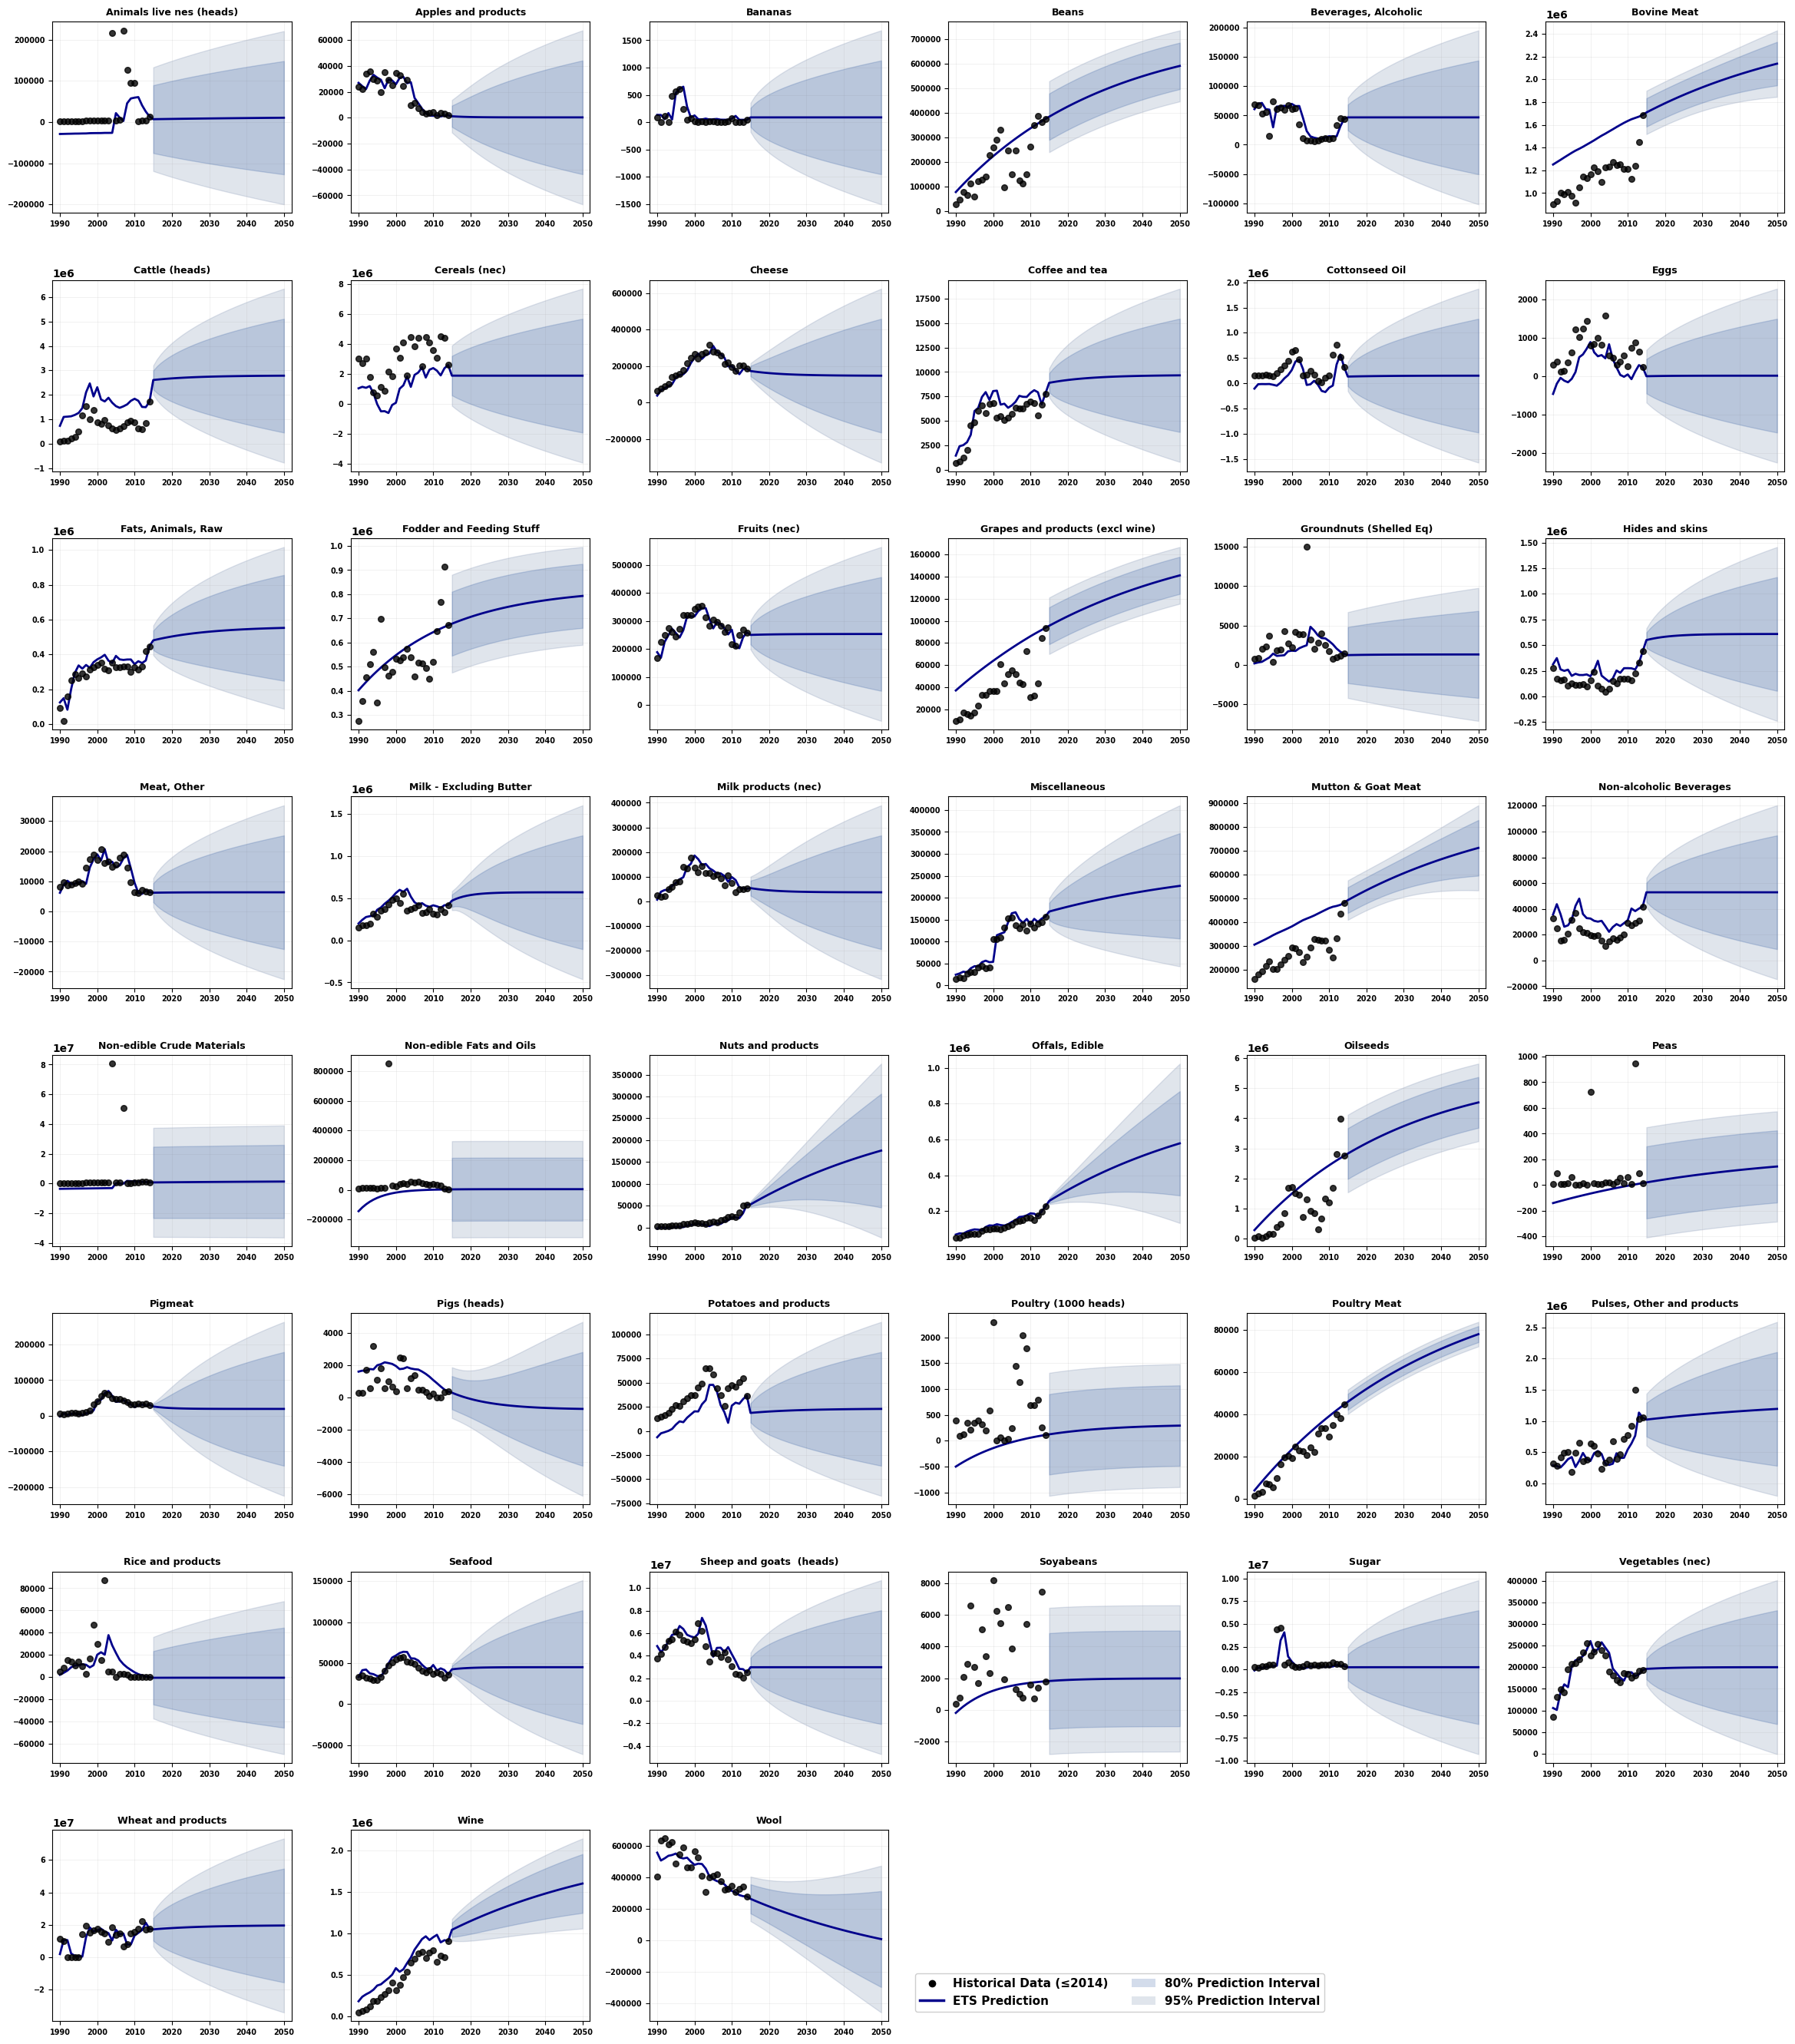


完成！


In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle
from pathlib import Path
from matplotlib.gridspec import GridSpec


def plot_all_exports_ets(df_hist: pd.DataFrame, trained_models: list, save_path: str):
    """
    使用 ETS 训练结果画图，所有Export商品在一张大图上
    """
    
    # 只选Export Quantity
    element_name = 'Export Quantity'
    
    # 筛选 Export 商品
    export_models = [m for m in trained_models if m['element'] == element_name]
    export_models = sorted(export_models, key=lambda x: x['group'])
    
    n_groups = len(export_models)
    print(f"总共 {n_groups} 个Export商品")
    
    # 计算子图布局
    n_cols = 6
    n_rows = int(np.ceil(n_groups / n_cols))
    
    print(f"布局:  {n_rows} 行 × {n_cols} 列")
    
    # 创建大图
    fig = plt.figure(figsize=(24, 3.5 * n_rows))
    gs = GridSpec(n_rows, n_cols, figure=fig, hspace=0.35, wspace=0.25,
                  left=0.04, right=0.98, top=0.98, bottom=0.05)
    
    # 为每个商品画子图
    for idx, model_result in enumerate(export_models):
        row = idx // n_cols
        col = idx % n_cols
        ax = fig.add_subplot(gs[row, col])
        
        group_name = model_result['group']
        df80 = model_result['df_80']
        df95 = model_result['df_95']
        last_hist_year = model_result['last_hist_year']
        
        # 筛选历史数据
        hist_data = df_hist[
            (df_hist['group'] == group_name) & 
            (df_hist['Element'] == element_name) &
            (df_hist['year'] <= 2014)
        ].copy()
        
        if hist_data.empty and df80.empty:
            ax.text(0.5, 0.5, 'No Data', ha='center', va='center', transform=ax.transAxes)
            ax.set_title(group_name, fontsize=9, fontweight='bold')
            continue
        
        # 排序
        if not hist_data.empty:
            hist_data = hist_data. sort_values('year')
        
        # 1. 画预测区间（只画 2015 之后的）
        # 95% 预测区间（浅灰色，底层）
        env95 = df95[df95['Year'] > last_hist_year]. copy()
        if not env95.empty:
            ax.fill_between(
                env95['Year']. to_numpy(),
                env95['Lower'].to_numpy(),
                env95['Upper'].to_numpy(),
                color='#082b6a', alpha=0.12, zorder=1
            )
        
        # 80% 预测区间（灰色，上层）
        env80 = df80[df80['Year'] > last_hist_year].copy()
        if not env80.empty:
            ax.fill_between(
                env80['Year'].to_numpy(),
                env80['Lower'].to_numpy(),
                env80['Upper'].to_numpy(),
                color='#0b3d91', alpha=0.18, zorder=2
            )
        
        # 2. 画预测均值线（深蓝色，从历史起始到 2050）
        if not df80.empty:
            ax. plot(df80['Year'], df80['Mean'], 
                   color='darkblue', linewidth=2, zorder=3)
        
        # 3. 画历史数据（黑色点，在最上层）
        if not hist_data.empty:
            ax.scatter(hist_data['year'], hist_data['trade'], 
                      color='black', s=30, zorder=5, alpha=0.8)
        
        # 4. 只保留标题（商品名称）
        ax. set_title(group_name, fontsize=9, fontweight='bold', pad=6)
        
        # 5. 网格
        ax.grid(True, alpha=0.25, linestyle='-', linewidth=0.5)
        
        # 6. 调整刻度字体大小
        ax.tick_params(labelsize=7)
        
        # 7. 设置x轴范围
        if not hist_data.empty:
            x_min = hist_data['year'].min() - 2
        else:
            x_min = 1988
        ax.set_xlim(x_min, 2052)
    
    # 隐藏多余的空白子图，并在最后一行放图例
    legend_placed = False
    for idx in range(n_groups, n_rows * n_cols):
        row = idx // n_cols
        col = idx % n_cols
        ax = fig.add_subplot(gs[row, col])
        
        # 在最后一行中间放图例
        if not legend_placed and row == n_rows - 1:
            ax.axis('off')
            # 创建图例元素
            from matplotlib.patches import Patch
            from matplotlib.lines import Line2D
            
            legend_elements = [
                Line2D([0], [0], marker='o', color='w', markerfacecolor='black', 
                       markersize=8, label='Historical Data (≤2014)'),
                Line2D([0], [0], color='darkblue', linewidth=2.5, label='ETS Prediction'),
                Patch(facecolor='#0b3d91', alpha=0.18, label='80% Prediction Interval'),
                Patch(facecolor='#082b6a', alpha=0.12, label='95% Prediction Interval'),
            ]
            
            ax.legend(handles=legend_elements, loc='lower right', fontsize=11, 
                frameon=True, framealpha=0.95, ncol=2, bbox_to_anchor=(1.6, 0.02))
            legend_placed = True
        else:
            ax.axis('off')
    
    # 保存
    plt.savefig(save_path, dpi=150, bbox_inches='tight', pad_inches=0.1)
    print(f"\n✓ 保存到:  {save_path}")
    
    plt.show()
    plt.close(fig)
    
    return fig


def main():
    # ========== 配置 ==========
    HIST_DATA_PATH = "../2_processed_data/trade_model_data_all.csv"
    MODEL_FILE = "../2_processed_data/trained_models_ets/all_trained_models_ets.pkl"
    OUTPUT_FILE = "./export_predictions_ets_all.png"
    
    # ========== 加载数据 ==========
    print("加载数据...")
    
    # 历史数据
    df_hist = pd.read_csv(HIST_DATA_PATH)
    df_hist = df_hist[df_hist["Report ISO"].str.upper() == "AUS"].copy()
    df_hist["year"] = pd.to_numeric(df_hist["year"], errors="coerce")
    df_hist["trade"] = pd.to_numeric(df_hist["trade"], errors="coerce")
    df_hist = df_hist.dropna(subset=["year", "trade"])
    
    # 聚合历史数据
    df_hist_agg = df_hist. groupby(["group", "Element", "year"], as_index=False)["trade"].sum()
    print(f"历史数据: {len(df_hist_agg)} 行")
    
    # ETS 训练结果
    if not Path(MODEL_FILE).exists():
        print(f"错误: 找不到模型文件 {MODEL_FILE}")
        print("请先运行 ETS 训练代码!")
        return
    
    with open(MODEL_FILE, 'rb') as f:
        trained_models = pickle.load(f)
    
    print(f"训练模型:  {len(trained_models)} 个\n")
    
    # ========== 画图 ==========
    plot_all_exports_ets(df_hist_agg, trained_models, OUTPUT_FILE)
    
    print("\n完成！")


if __name__ == "__main__":
    main()

加载数据...
历史数据: 2250 行
训练模型:  90 个

总共 45 个Export商品
布局:  8 行 × 6 列

✓ 保存到:  ./export_predictions_ets_all.png


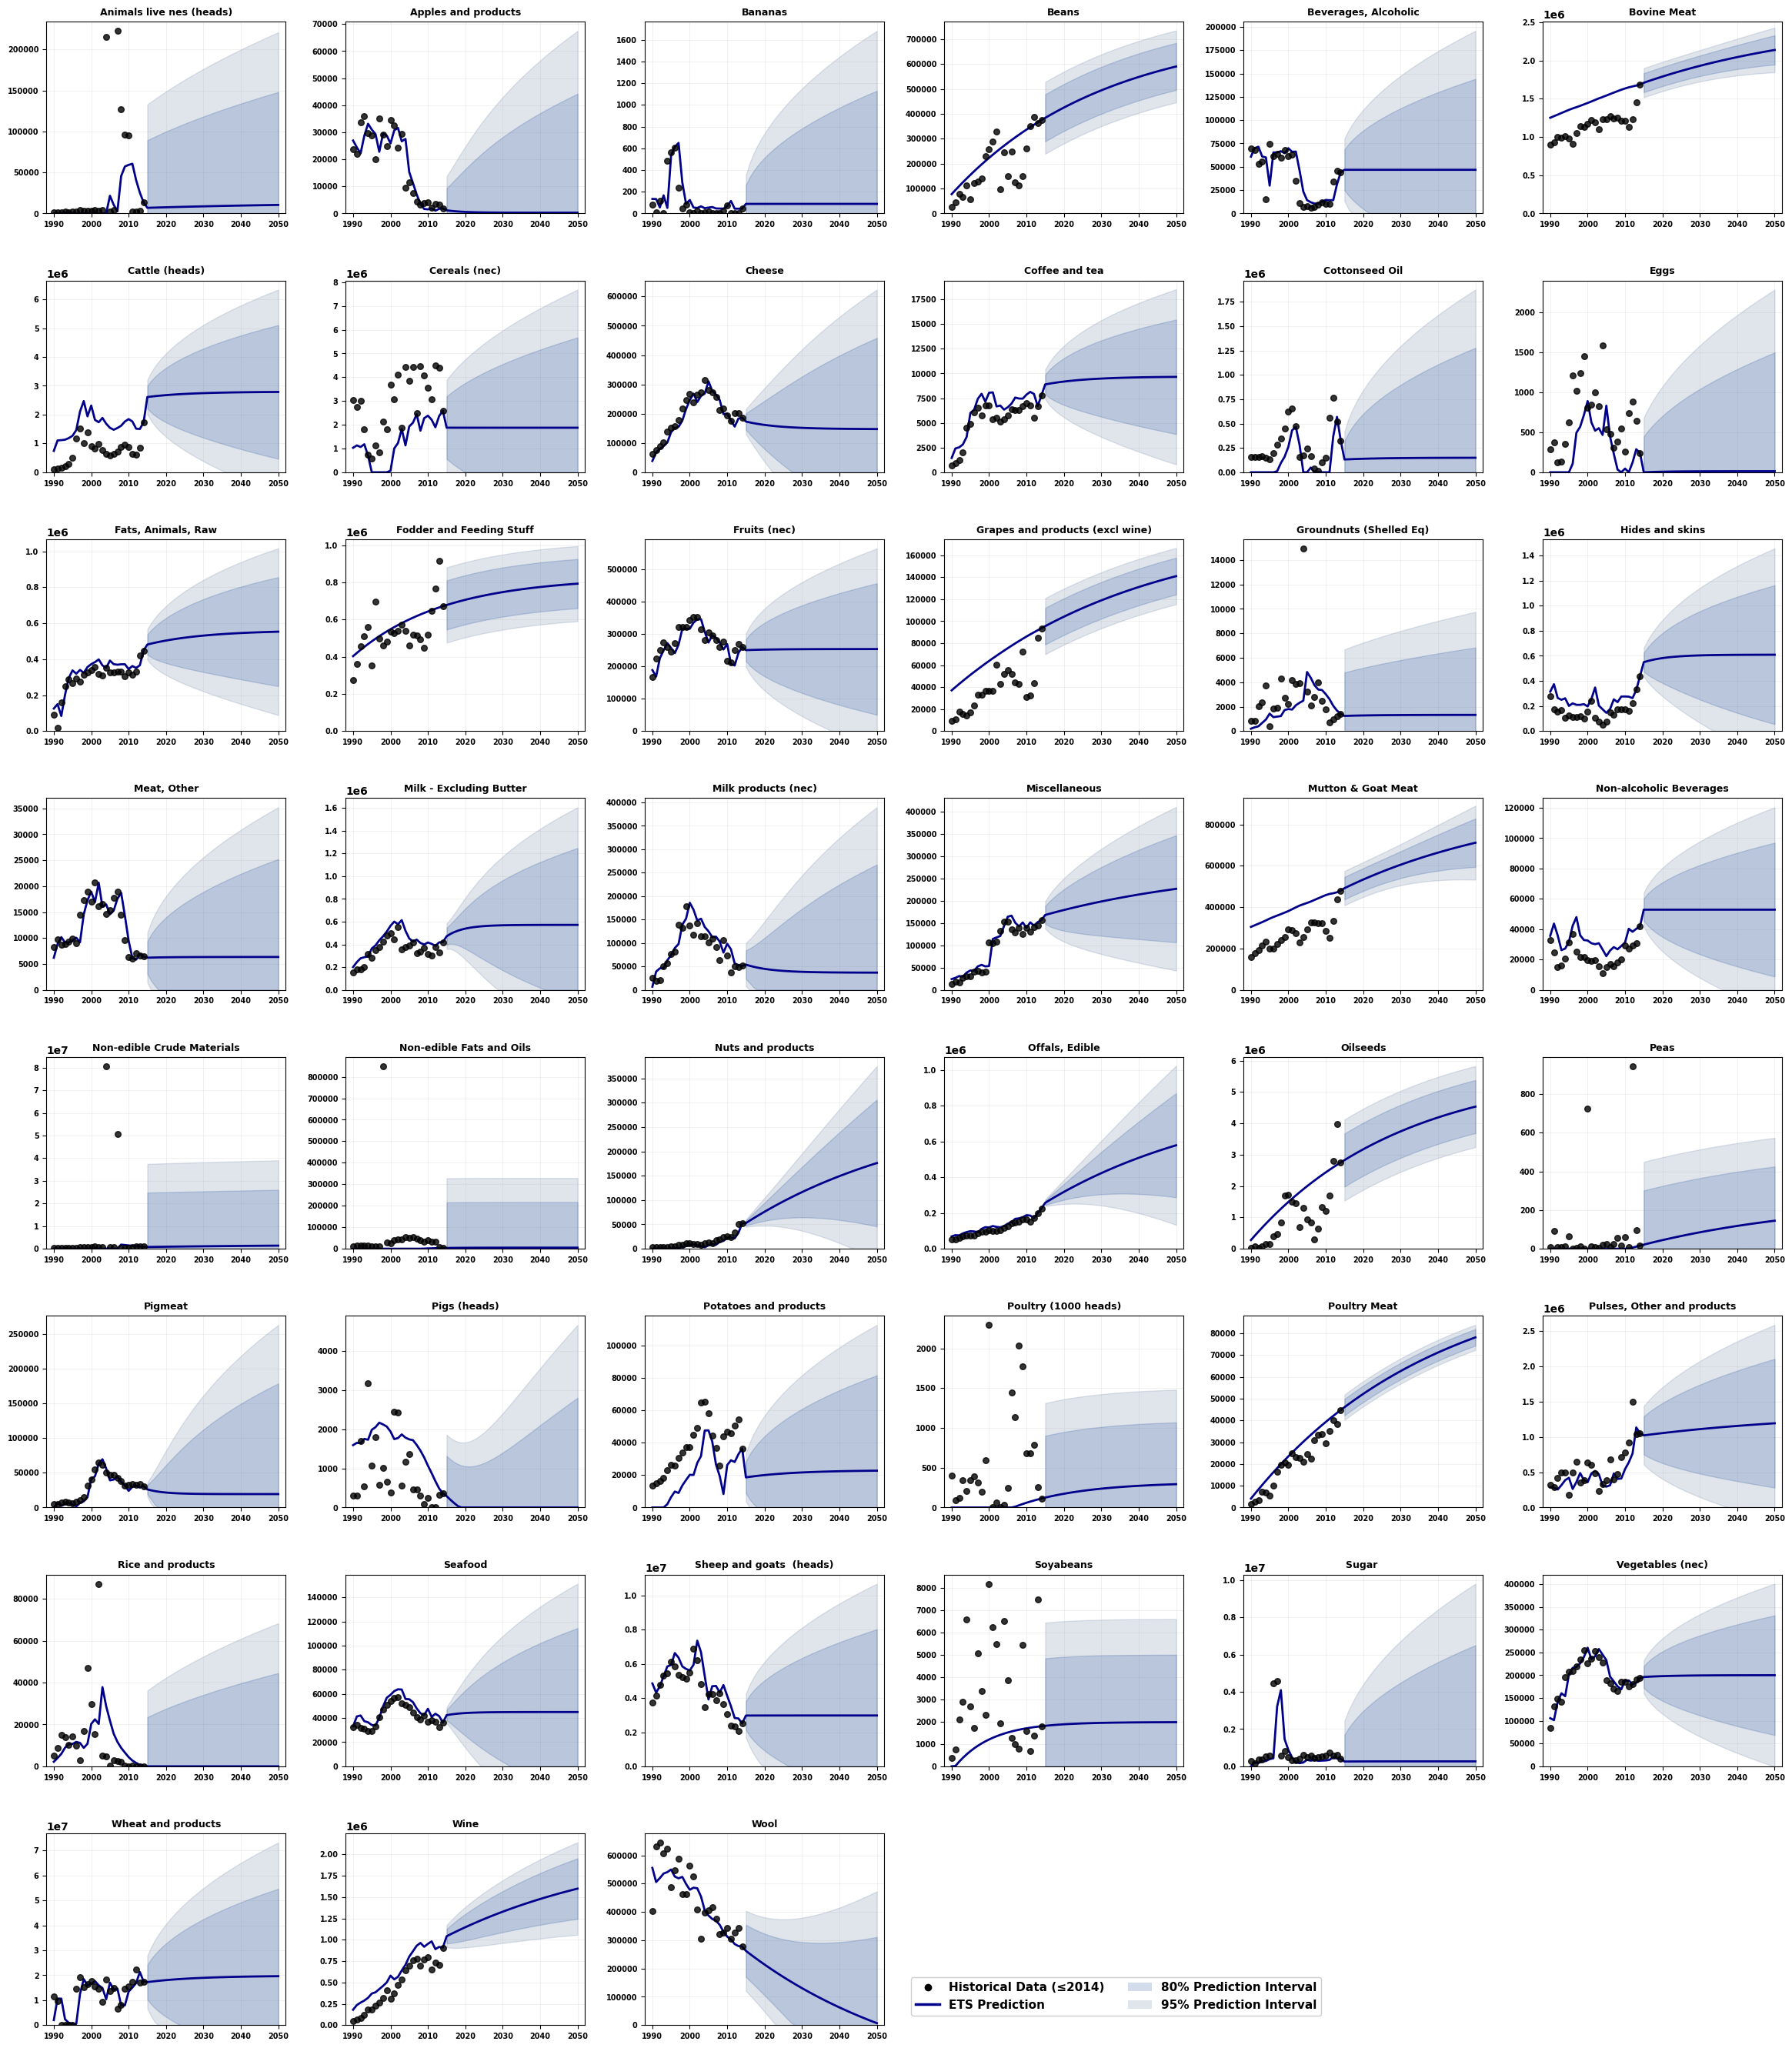


完成！


In [50]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle
from pathlib import Path
from matplotlib.gridspec import GridSpec


def plot_all_exports_ets(df_hist: pd. DataFrame, trained_models: list, save_path: str):
    """
    使用 ETS 训练结果画图，所有Export商品在一张大图上
    添加零下限（zero floor）
    """
    
    # 只选Export Quantity
    element_name = 'Export Quantity'
    
    # 筛选 Export 商品
    export_models = [m for m in trained_models if m['element'] == element_name]
    export_models = sorted(export_models, key=lambda x:  x['group'])
    
    n_groups = len(export_models)
    print(f"总共 {n_groups} 个Export商品")
    
    # 计算子图布局
    n_cols = 6
    n_rows = int(np.ceil(n_groups / n_cols))
    
    print(f"布局:  {n_rows} 行 × {n_cols} 列")
    
    # 创建大图
    fig = plt.figure(figsize=(24, 3.5 * n_rows))
    gs = GridSpec(n_rows, n_cols, figure=fig, hspace=0.35, wspace=0.25,
                  left=0.04, right=0.98, top=0.98, bottom=0.05)
    
    # 为每个商品画子图
    for idx, model_result in enumerate(export_models):
        row = idx // n_cols
        col = idx % n_cols
        ax = fig.add_subplot(gs[row, col])
        
        group_name = model_result['group']
        df80 = model_result['df_80']. copy()  # 复制以避免修改原数据
        df95 = model_result['df_95']. copy()
        last_hist_year = model_result['last_hist_year']
        
        # ========== 应用零下限（zero floor） ==========
        for col_name in ['Mean', 'Lower', 'Upper']:
            df80[col_name] = np.maximum(df80[col_name], 0)
            df95[col_name] = np.maximum(df95[col_name], 0)
        # =============================================
        
        # 筛选历史数据
        hist_data = df_hist[
            (df_hist['group'] == group_name) & 
            (df_hist['Element'] == element_name) &
            (df_hist['year'] <= 2014)
        ].copy()
        
        if hist_data.empty and df80.empty:
            ax.text(0.5, 0.5, 'No Data', ha='center', va='center', transform=ax.transAxes)
            ax.set_title(group_name, fontsize=9, fontweight='bold')
            continue
        
        # 排序
        if not hist_data. empty:
            hist_data = hist_data. sort_values('year')
        
        # 1. 画预测区间（只画 2015 之后的）
        # 95% 预测区间（浅灰色，底层）
        env95 = df95[df95['Year'] > last_hist_year]. copy()
        if not env95.empty:
            ax.fill_between(
                env95['Year']. to_numpy(),
                env95['Lower'].to_numpy(),
                env95['Upper'].to_numpy(),
                color='#082b6a', alpha=0.12, zorder=1
            )
        
        # 80% 预测区间（灰色，上层）
        env80 = df80[df80['Year'] > last_hist_year].copy()
        if not env80.empty:
            ax.fill_between(
                env80['Year'].to_numpy(),
                env80['Lower']. to_numpy(),
                env80['Upper'].to_numpy(),
                color='#0b3d91', alpha=0.18, zorder=2
            )
        
        # 2. 画预测均值线（深蓝色，从历史起始到 2050）
        if not df80.empty:
            ax. plot(df80['Year'], df80['Mean'], 
                   color='darkblue', linewidth=2, zorder=3)
        
        # 3. 画历史数据（黑色点，在最上层）
        if not hist_data.empty:
            ax.scatter(hist_data['year'], hist_data['trade'], 
                      color='black', s=30, zorder=5, alpha=0.8)
        
        # 4. 只保留标题（商品名称）
        ax. set_title(group_name, fontsize=9, fontweight='bold', pad=6)
        
        # 5. 网格
        ax.grid(True, alpha=0.25, linestyle='-', linewidth=0.5)
        
        # 6. 调整刻度字体大小
        ax.tick_params(labelsize=7)
        
        # 7. 设置x轴和y轴范围
        if not hist_data.empty:
            x_min = hist_data['year'].min() - 2
        else:
            x_min = 1988
        ax.set_xlim(x_min, 2052)
        
        # ========== 设置y轴下限为0 ==========
        y_min, y_max = ax.get_ylim()
        ax.set_ylim(0, y_max)  # 确保y轴从0开始
        # ====================================
    
    # 隐藏多余的空白子图，并在最后一行放图例
    legend_placed = False
    for idx in range(n_groups, n_rows * n_cols):
        row = idx // n_cols
        col = idx % n_cols
        ax = fig.add_subplot(gs[row, col])
        
        # 在最后一行中间放图例
        if not legend_placed and row == n_rows - 1:
            ax.axis('off')
            # 创建图例元素
            from matplotlib. patches import Patch
            from matplotlib.lines import Line2D
            
            legend_elements = [
                Line2D([0], [0], marker='o', color='w', markerfacecolor='black', 
                       markersize=8, label='Historical Data (≤2014)'),
                Line2D([0], [0], color='darkblue', linewidth=2.5, label='ETS Prediction'),
                Patch(facecolor='#0b3d91', alpha=0.18, label='80% Prediction Interval'),
                Patch(facecolor='#082b6a', alpha=0.12, label='95% Prediction Interval'),
            ]
            
            ax.legend(handles=legend_elements, loc='lower right', fontsize=11, 
                     frameon=True, framealpha=0.95, ncol=2, bbox_to_anchor=(1.6, 0.02))
            legend_placed = True
        else:
            ax. axis('off')
    
    # 保存
    plt. savefig(save_path, dpi=150, bbox_inches='tight', pad_inches=0.1)
    print(f"\n✓ 保存到:  {save_path}")
    
    plt.show()
    plt.close(fig)
    
    return fig


def main():
    # ========== 配置 ==========
    HIST_DATA_PATH = "../2_processed_data/trade_model_data_all.csv"
    MODEL_FILE = "../2_processed_data/trained_models_ets/all_trained_models_ets.pkl"
    OUTPUT_FILE = "./export_predictions_ets_all.png"
    
    # ========== 加载数据 ==========
    print("加载数据...")
    
    # 历史数据
    df_hist = pd.read_csv(HIST_DATA_PATH)
    df_hist = df_hist[df_hist["Report ISO"]. str.upper() == "AUS"].copy()
    df_hist["year"] = pd.to_numeric(df_hist["year"], errors="coerce")
    df_hist["trade"] = pd. to_numeric(df_hist["trade"], errors="coerce")
    df_hist = df_hist.dropna(subset=["year", "trade"])
    
    # 聚合历史数据
    df_hist_agg = df_hist. groupby(["group", "Element", "year"], as_index=False)["trade"].sum()
    print(f"历史数据: {len(df_hist_agg)} 行")
    
    # ETS 训练结果
    if not Path(MODEL_FILE).exists():
        print(f"错误:  找不到模型文件 {MODEL_FILE}")
        print("请先运行 ETS 训练代码!")
        return
    
    with open(MODEL_FILE, 'rb') as f:
        trained_models = pickle.load(f)
    
    print(f"训练模型:  {len(trained_models)} 个\n")
    
    # ========== 画图 ==========
    plot_all_exports_ets(df_hist_agg, trained_models, OUTPUT_FILE)
    
    print("\n完成！")


if __name__ == "__main__": 
    main()